# BARB API Demo: A media agency case study


## The brief

In this demo of the BARB API we will demonstrate a typical media agency use case.

The agency has run a TV advertising campaign for their client. As part of their post campaign analysis they would like to understand how well the adverts have performed

1. By TV station
2. By audience 
3. And over time.   

## The API documentation

Our first step is to examine the API documentation which can be found [here](). Specificially we will be interested in the [advertising spot]() endpoint and the [buyer]() and [advertiser]() metadata end points.

We might also look at the [Getting Started]() section for information about authentication and basic API usage.

## Set up the python environment

Next we set up our notebook with all the libraries we will need to access the API and analyse the data.

In [1]:
import requests
import numpy as np
import json
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "jupyterlab"

## Get the access token

Following the steps in the Getting Started guide we run some python code to get an access token. This code uses your account details to get an access token from the API. Your creds.json file should include the email and password supplied by BARB. For example:

```
{"email": "me@coppelia.io", "password": "INSERT PASSWORD"}
```

In [2]:
with open("creds.json") as file:
    creds = json.loads(file.read())
api_root = "https://uat.barb-api.co.uk/api/v1/"
token_request_url = api_root + "auth/token/"
response = requests.post(token_request_url, data = creds)
access_token = json.loads(response.text)['access']
headers = {'Authorization': 'Bearer {}'.format(access_token)}

## Get data from the API

Let's say as the media agency Mindshare we are interested in the Persil campaign that was shown over for our client Unilever. If we don't have it already our first use of the APIs is to find out our own buyer code.

### The buyer code

In [3]:
headers = {'Authorization': 'Bearer {}'.format(access_token)}
api_url = api_root + "buyers/"
response = requests.get(url = api_url,headers=headers)
buyers = response.json()
[b for b in buyers if "mindshare" in b]

### The advertiser code

We could bring back all the data for Mindshare but it would be better to limit it to the spots that were placed for Unilever. For this we need the right code for Unilever home products. 

In [4]:
api_url = api_root + "advertisers/"
response = requests.get(url = api_url,headers=headers)
advertisers = response.json()
advertisers
[a for a in advertisers if "unilever" in a]

['unilever_bestfoods',
 'unilever_ice_cream_&',
 'unilever_ireland',
 'unilever_uk_home_&_p']

### The panel code

Finally, we are only interested in the BBC Network panel so we can use the [panels]() end point to get the right code.

In [5]:
api_url = api_root + "panels/"
response = requests.get(url = api_url,headers=headers)
panels = response.json()
[p for p in panels if "bbc network" in p['panel_region'].lower()]

[{'panel_code': 50, 'panel_region': 'BBC Network', 'is_macro_region': False}]

### Querying the advertising spots endpoint

Now we know all the relevant metadata we can query the advertising spots endpoint. We use the following code to reshape the data into the format we need for analysis.

In [6]:
# A function to reshape the data in the way that we want it

def json_to_table(api_data):
    
    print("Downloading and processing {} programme events".format(len(api_data["events"])))
    
    # Loop through the events and then the audiences within the events
    spot_data = []
    for e in api_data['events']:
        for v in e['audience_views']:
            spot_data.append({'panel_region': e['panel']['panel_region'],
                          'station_name': e['station']['station_name'],
                          'clearcast_commercial_title': e['clearcast_information']['clearcast_commercial_title'],
                                        'spot_start_datetime': e['spot_start_datetime']['standard_datetime'],
                                        'audience_code': v['audience_code'],
                                        'audience_size_hundreds': v['audience_size_hundreds']})
    # Convert the result into a data frame
    spot_data = pd.DataFrame(spot_data)

    # Format the transmission_time_period as a pandas datetime
    spot_data['spot_start_datetime'] = pd.to_datetime(spot_data['spot_start_datetime'])

    # Add the audience category names. We have a temporary problem with duplicates in this data set hence the dropping of duplicates.
    audience_categories_df = pd.DataFrame(api_data['audience_categories']).drop_duplicates(subset=['audience_code'])
    spot_data = spot_data.merge(audience_categories_df, how="left", on = "audience_code").drop("audience_code", axis=1)
    
    return spot_data

Note that we are using the `x_next_url` to download the data in chunks.

In [7]:
api_url = api_root + "advertising_spots/"

# The query parameters
params = {"min_transmission_date": "2022-01-01","max_transmission_date":"2022-04-01", 
          "buyer_name": "mindshare_media_uk_l", 
          "advertiser_name": "unilever_uk_home_&_p",
          "panel_code": 50,
         "consolidated": True, "limit": 5000}

# Query the API and turn the response into json
total_events_count = 0
r = requests.get(url=api_url, params=params, headers=headers)
api_data = r.json()
spot_data = json_to_table(api_data)
while r.headers.__contains__("X-Next"):
    x_next_url = r.headers["X-Next"]
    r = requests.get(url=x_next_url, headers=headers)
    data_increment = r.json()
    spot_data = pd.concat([spot_data, json_to_table(data_increment)])

Let's take a look at the data

In [8]:
spot_data.head()

,panel_region,station_name,clearcast_commercial_title,spot_start_datetime,audience_size_hundreds,audience_name,audience_target_size_hundreds
0,BBC Network,Discovery,Persil Gaia 30,2022-03-14 18:31:40,102,All Homes,270890
1,BBC Network,Discovery,Persil Gaia 30,2022-03-14 18:31:40,102,All Adults,513120
2,BBC Network,Discovery,Persil Gaia 30,2022-03-14 18:31:40,102,All Men,250100
3,BBC Network,Discovery,Persil Gaia 30,2022-03-14 18:31:40,102,All Houseperson,270890
4,BBC Network,Discovery,Persil Gaia 30,2022-03-14 18:31:40,102,Adults 35-44,81760


It's worth noting just how much data we have downloaded from the API in a short amount of time.

In [9]:
spot_data.shape

(115196, 7)

## Analysing the Persil campaign

### On average how did each station perform?

Let's limit the data to Persil adverts

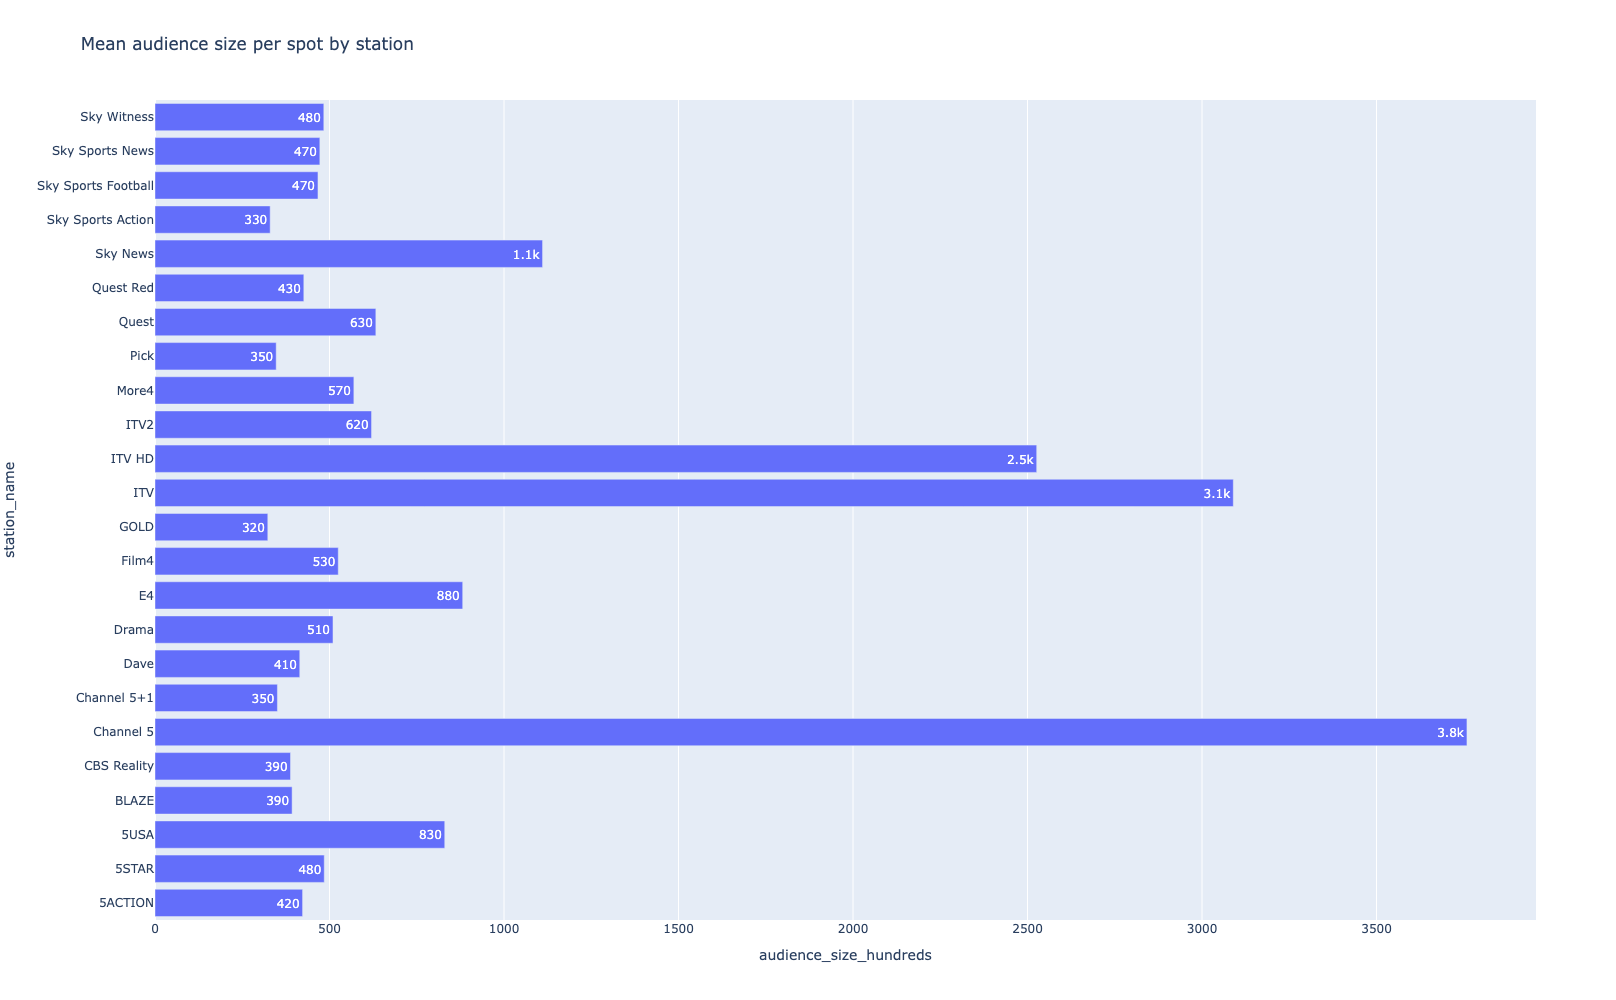

In [10]:
persil = spot_data[spot_data['clearcast_commercial_title'].str.contains("Persil")]
group_by_station = persil[persil['audience_name']=="All Homes"].groupby('station_name')['audience_size_hundreds'].mean().reset_index()

fig = px.bar(group_by_station[group_by_station["audience_size_hundreds"]>300], x='audience_size_hundreds', y='station_name', text_auto='.2s',
            title="Mean audience size per spot by station", height=1000)
fig.show()

### On average for each audience and station what percentage of the target audience was reached

In [11]:
persil=persil.assign(audience_penetration = persil['audience_size_hundreds']/persil['audience_target_size_hundreds'])
group_by_audience_and_station = persil.groupby(['audience_name', 'station_name'])['audience_penetration'].mean()
group_by_audience_and_station = group_by_audience_and_station[group_by_audience_and_station>0.003].unstack().fillna(0)

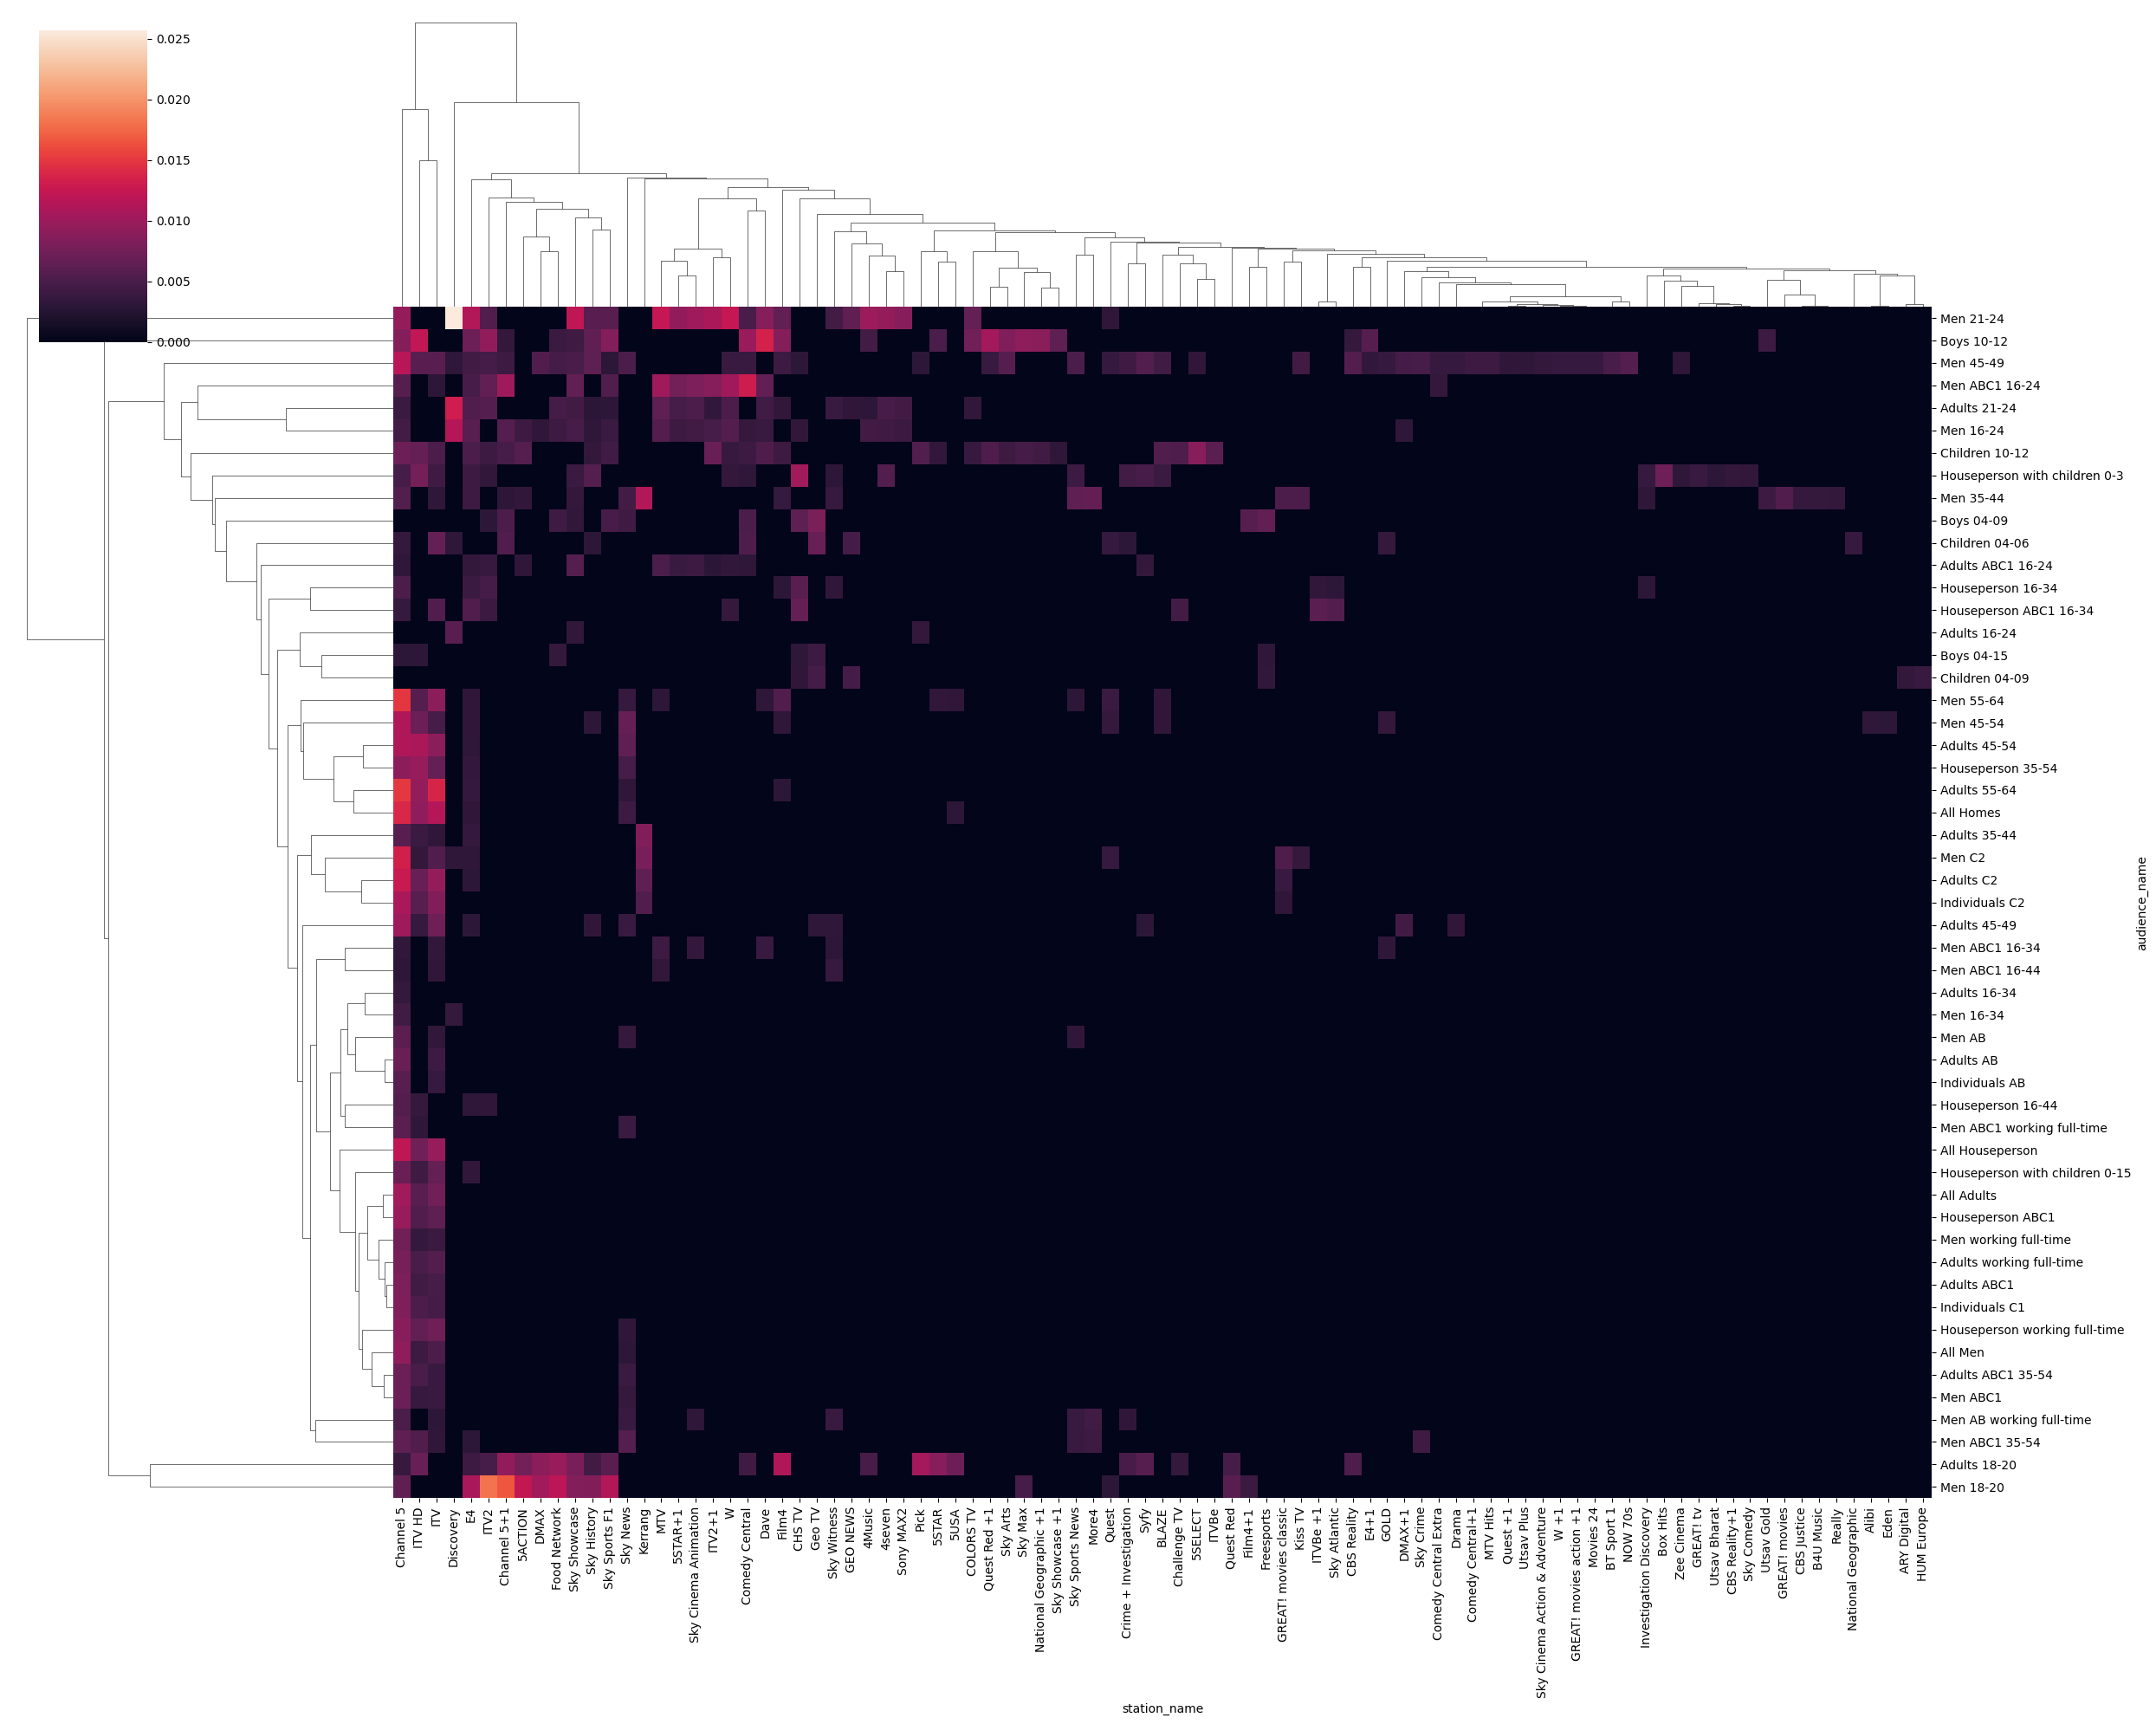

In [12]:
_ = sns.clustermap(group_by_audience_and_station, figsize = (25,20))

## How did the spots do over time?

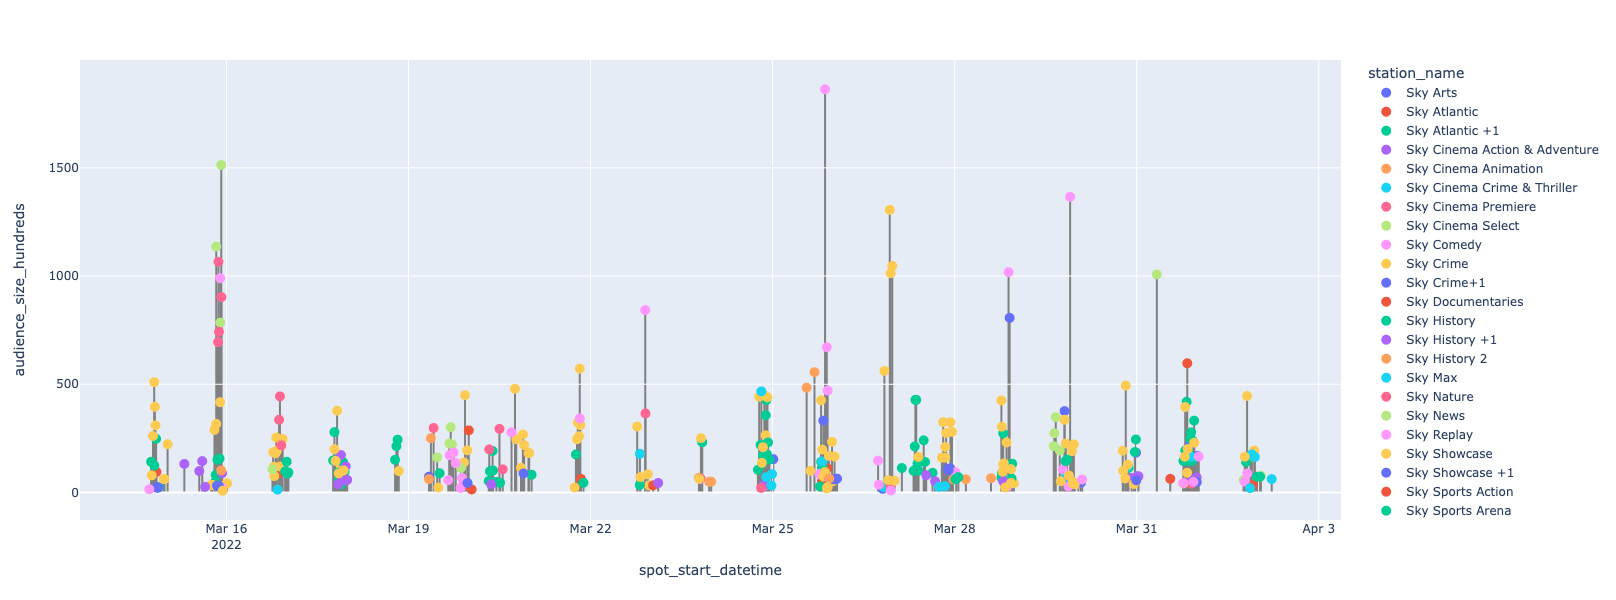

In [13]:
persil_sky = spot_data[(spot_data['clearcast_commercial_title'].str.contains("Persil")) 
                   & (spot_data['audience_name']=='All Homes')
                   & (spot_data['station_name'].str.contains("Sky"))].sort_values(['station_name', 'spot_start_datetime'])

fig = px.scatter(persil_sky, x="spot_start_datetime", y="audience_size_hundreds", color="station_name", width = 1400, height = 600)
fig.update_traces(marker={'size': 10})

shapes=[dict(
        type='line',
        x0 = persil_sky['spot_start_datetime'].iloc[i],
        y0 = 0,
        x1 = persil_sky['spot_start_datetime'].iloc[i],
        y1 = persil_sky['audience_size_hundreds'].iloc[i],
        layer='below',
        line = dict(
            color = 'grey',
            width = 2
        )
    ) for i in range(len(persil_sky['audience_size_hundreds']))]

fig.update_layout(shapes = shapes)